# Sparse Document Retriever - Experimento

Preencha aqui com detalhes sobre a tarefa.<br>
### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [1]:
dataset = "/tmp/data/expanded_en-6.csv" #@param {type:"string"}
column_context = "context" #@param {type:"string",label:"Coluna do dataframe de entrada com os contextos para ranquear"}
question = "Qual é o melhor herbicida para erva da ninha ?" #@param {type:"string",label:"Pergunta para a qual os contextos devem ser ranqueados"}

#Hyperparams
retriever_type = "tfidf" #@param ["bm25","tfidf","word2vec"] {type:"string",label:"Tipo de retriever esparço",description:"O retriever pode ser BM25 Okapi, TF-IDF e Word2Vec"}
bm25_k1 = 2 #@param {type:"integer",label:"Argumento k1 do BM25",description:"O argumento k1 do bm25 representa as características da frequência de saturação dos tokens. Ou seja, ele limita o quando cada token pode afetar o score do documento"}
bm25_b = 0.75 #@param {type:"integer",label:"Argumento b do BM25",label:"O argumento b do bm25 é determina o efeito do tamanho de um documento comparado com a média. Quanto maior b maior o efeito}
top = 10 #@param {type:"integer",label:"Quantidade de contextos para retornados"}
column_doc_id = "doc_id" #@param {type:"string",label:"Coluna com o ID do contexto",description:"Nome da coluna que contexto os ids dos contextos a serem ranqueados"}
column_score = "retriever_score" #@param {type:"string",label:"Coluna com o score",description:"Nome da coluna que conterá o score dos contextos ranqueados após a inferência do modelo"}

In [2]:
if bm25_b<0 or bm25_b>1:
    raise ValueError("O valor de bm25_b deve estar entre 0 e 1")
    
if bm25_k1<1:
    raise ValueError("O valor de bm25_k1 deve ser maior ou igual a 1")

# Acesso ao conjunto de dados¶
O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.
O tipo da variável retornada depende do arquivo de origem:

* pandas.DataFrame para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
* Binary IO stream para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [3]:
import pandas as pd

df = pd.read_csv(dataset)
columns = df.columns

## Conteúdo da tarefa

In [4]:
import numpy as np
from model_sparse_retriever import TfidfRetriever, W2VRetriever, BM25Retriever
from aux_functions import build_result_dataframe

if retriever_type == "bm25":
    kwargs={'k1':bm25_k1,'b':bm25_b}
    retriever = BM25Retriever(**kwargs)
elif retriever_type == "tfidf":
    retriever = TfidfRetriever()
elif retriever_type == "word2vec":
    ! wget -nc https://storage.googleapis.com/platiagro/Vident/glove_s300_portugues.txt
    from gensim.models import KeyedVectors
    model = KeyedVectors.load_word2vec_format('glove_s300_portugues.txt')
    retriever = W2VRetriever(w2v_model=model)

report_contexts = df[column_context].to_numpy()
retriever.fit(contexts=report_contexts)
sim_contexts_ids, scores = retriever(questions=question, top=top)
column_doc_ids = df[column_doc_id].to_numpy()
sim_contexts_ids = np.array([column_doc_ids[k] for k in sim_contexts_ids[0]])

In [5]:
df_result = build_result_dataframe(df_input=df,
                            sim_contexts_ids=sim_contexts_ids,
                            scores=scores[0],
                            column_doc_id = column_doc_id,
                            column_score = column_score)

## Visualizando os resultados

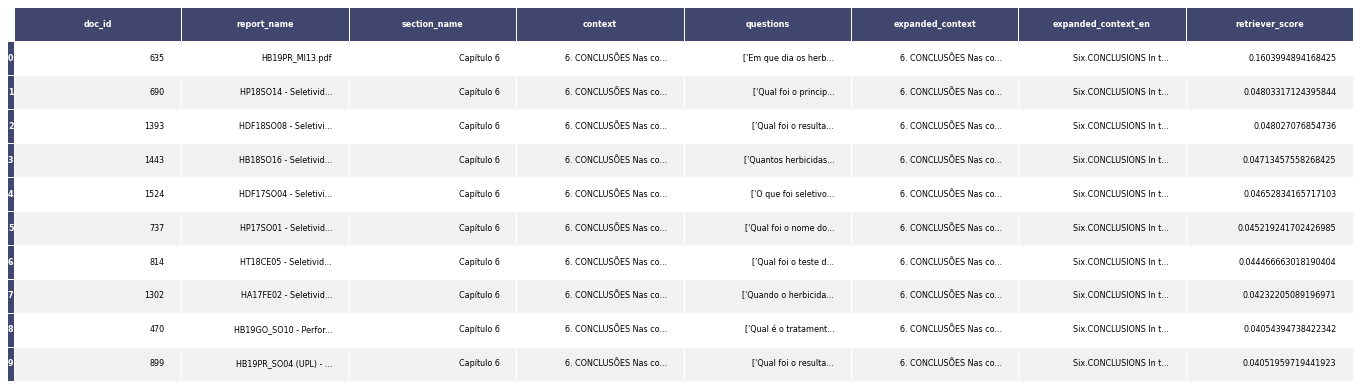

In [6]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table

ax = plot_data_table(df_result)
plt.show()

In [7]:
df_result.to_csv(dataset, index=False)

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [8]:
from joblib import dump

artifacts = {
    "model":retriever,
    "top":top,
    "question":question,
    "columns":columns,
    "column_context":column_context,
    "column_doc_id":column_doc_id,
    "column_score":column_score,
}

dump(artifacts, "/tmp/data/sparse_retriever.joblib")

['/tmp/data/sparse_retriever.joblib']